In [51]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data65


In [52]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

# 手写数字识别

## 导包

In [53]:
import paddle
import numpy as np
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
import matplotlib.pyplot as plt


## 定义卷积神经网络LeNet

In [54]:
class LeNet(paddle.nn.Layer):
    def __init__(self, num_classes=2):  # num_classes为分类类数
        super(LeNet, self).__init__()
        self.conv1 = Conv2D(in_channels=1, out_channels=6, kernel_size=5) 
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        self.conv3 = Conv2D(in_channels=16, out_channels=120, kernel_size=4)
        self.fc1 = Linear(in_features=120, out_features=64)
        self.fc2 = Linear(in_features=64, out_features=num_classes)
    
    def forward(self, x):                   #[ N ,1,28,28]
        x = self.conv1(x)                   #[ N ,6,24,24]
        x = F.sigmoid(x)                    #[ N ,6,24,24]
        x = self.max_pool1(x)               #[ N ,6,12,12]
        x = F.sigmoid(x)                    #[ N ,6,12,12]
        x = self.conv2(x)                   #[ N ,16,8,8]
        x = self.max_pool2(x)               #[ N ,16,4,4]
        x = self.conv3(x)                   #[ N ,120,1,1]
        x = paddle.reshape(x, [x.shape[0], -1])   #[ N ,120]
        x = self.fc1(x)                     #[ N ,64]
        x = F.sigmoid(x)                    #[ N ,64]
        x = self.fc2(x)                     #[ N ,10]
        return x


## 定义训练函数

In [55]:
import imp
from paddle.vision.transforms import ToTensor
from paddle.vision.datasets import MNIST


def train(model, opt, train_loader, valid_loader):
    use_gpu = True
    #paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')
    print('-----------start training----------')

    # 训练模式
    model.train()

    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            img = data[0]              #[10,1,28,28]
            label = data[1]            #[10,1]
            # 计算模型输出
            logits = model(img)
            # 计算损失函数
            loss_func = paddle.nn.CrossEntropyLoss(reduction='none')
            loss = loss_func(logits, label)
            avg_loss = paddle.mean(loss)


            if batch_id % 500 == 0:
                print("epoch: {}, batch_id: {:4}, loss is: {:.4f}".format(epoch+1, batch_id, float(avg_loss.numpy())))
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

        # 切换评价模式
        model.eval()

        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            img = data[0]
            label = data[1] 
            # 计算模型输出
            logits = model(img)
            # 计算损失函数
            loss_func = paddle.nn.CrossEntropyLoss(reduction='none')
            loss = loss_func(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())

        global all_train_iter  
        all_train_iter = all_train_iter + 1
        all_train_iters.append(all_train_iter)
        all_train_costs.append(np.mean(losses))
        all_train_accs.append(np.mean(accuracies))

        
        print("[validation] accuracy/loss: {:.4f}/{:.4f}".format(np.mean(accuracies), np.mean(losses)))
        
        model.train()    # 再次切换到训练模式

    # 保存模型参数
    paddle.save(model.state_dict(), 'mnist_num_OCR.pdparams')


    print('-----------finish training----------')

## 定义绘制模型训练曲线函数

In [56]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

## 主函数

-----------start training----------
epoch: 1, batch_id:    0, loss is: 2.4507
epoch: 1, batch_id:  500, loss is: 2.3270
epoch: 1, batch_id: 1000, loss is: 2.2813
epoch: 1, batch_id: 1500, loss is: 2.2350
epoch: 1, batch_id: 2000, loss is: 2.2141
epoch: 1, batch_id: 2500, loss is: 2.3076
epoch: 1, batch_id: 3000, loss is: 2.1791
epoch: 1, batch_id: 3500, loss is: 2.0481
epoch: 1, batch_id: 4000, loss is: 1.4203
epoch: 1, batch_id: 4500, loss is: 1.1195
epoch: 1, batch_id: 5000, loss is: 0.9389
epoch: 1, batch_id: 5500, loss is: 0.4750
[validation] accuracy/loss: 0.8166/0.6720
epoch: 2, batch_id:    0, loss is: 0.9963
epoch: 2, batch_id:  500, loss is: 0.5001
epoch: 2, batch_id: 1000, loss is: 0.3467
epoch: 2, batch_id: 1500, loss is: 0.4494
epoch: 2, batch_id: 2000, loss is: 0.3334
epoch: 2, batch_id: 2500, loss is: 0.2296
epoch: 2, batch_id: 3000, loss is: 0.4526
epoch: 2, batch_id: 3500, loss is: 0.2183
epoch: 2, batch_id: 4000, loss is: 0.3674
epoch: 2, batch_id: 4500, loss is: 0.121

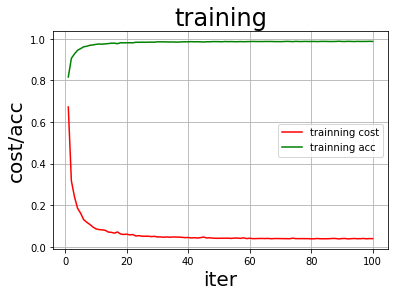

In [57]:
# 实例化模型
model = LeNet(num_classes=10) # 10分类
# 训练轮数
EPOCH_NUM = 100
# 设置优化器
opt = paddle.optimizer.Momentum(learning_rate=0.001, parameters=model.parameters())
# 数据集加载（同时进行10张）
train_loader = paddle.io.DataLoader(MNIST(mode='train', transform=ToTensor()), batch_size=10, shuffle=True)
valid_loader = paddle.io.DataLoader(MNIST(mode='test', transform=ToTensor()), batch_size=10)
# 绘制曲线准备
all_train_iter = 0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

# 训练
train(model, opt, train_loader, valid_loader)

# 绘制曲线
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 